In [1]:
# -------------------- Imports -------------------- #
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten
from keras.models import Model
import numpy as np, pandas as pd, os
from prettytable import PrettyTable
from matplotlib import pyplot as plt
import math

Using TensorFlow backend.


In [2]:
# -------------------- Globals and Configs -------------------- #
feature_names = list()
for index in range(1, 6):
    feature_names.extend(["Suit"+str(index), "Rank"+str(index)])

feature_names.append('class')


training_input_file = os.path.abspath('../datasets/csv/train.csv')
testing_input_file = os.path.abspath('../datasets/csv/test.csv')

np.random.seed(666)     # seed for reproducible results

# To store configs
class myConfigs:
    features = 0
    classes = 0


config = myConfigs()

In [3]:
# -------------------- Data -------------------- #

train_data = pd.read_csv(training_input_file, names=feature_names)
test_data = pd.read_csv(testing_input_file, names=feature_names)

# Get features of data
config.features = len(train_data.columns) - 1
config.classes = len(set(train_data['class']))

# Shuffle training data
train_data = train_data.sample(frac=1).reset_index(drop=True)

# Seperate data and classes
train_y = np.array(train_data['class'])
train_x = np.array(train_data.drop('class', 1))

test_y = np.array(test_data['class'])
test_x = np.array(test_data.drop('class', 1))

train_y_onehot = list()
for y in range(len(train_y)):
    temp = [0] * config.classes
    temp[train_y[y]] = 1
    train_y_onehot.append(temp)
    
test_y_onehot = list()
for y in range(len(test_y)):
    temp = [0] * config.classes
    temp[test_y[y]] = 1
    test_y_onehot.append(temp)
    
train_y_onehot = np.array(train_y_onehot)
test_y_onehot = np.array(test_y_onehot)

tab = PrettyTable(['Config', 'Value'])
configs = vars(config)

for key in configs:
    tab.add_row([key, configs[key]])
print(tab)

print("Instances in training data :", len(train_data))
print("Instances in testing data :", len(test_data))

+----------+-------+
|  Config  | Value |
+----------+-------+
| features |   10  |
| classes  |   10  |
+----------+-------+
Instances in training data : 25010
Instances in testing data : 1000000


In [4]:
# -------------------- Model -------------------- #
model = Sequential()

# Input layer
model.add(Dense(10, input_shape = (train_x.shape[1],), activation='tanh'))

# Hidden layer
model.add(Dense(64, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(64, activation='tanh'))

# Output layer
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_x, train_y_onehot, epochs = 450, batch_size = 500, verbose=0)

Matches : 21978 / 25010 = 87.87684926029588
Average Error : 0.14566173530587764
RMSE : 0.4909008113227937


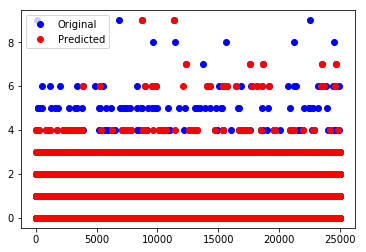

In [5]:
preds = [list(x) for x in model.predict(train_x)]
for i in range(len(preds)):
    preds[i] = preds[i].index(max(preds[i]))

train_matches = 0
for i in range(len(train_y)):
    if train_y[i] == preds[i]:
        train_matches += 1
        
print("Matches :", train_matches, '/', len(train_y), '=', train_matches/len(train_y) * 100)
print("Average Error :", sum([math.fabs(x-y) for x, y in zip(train_y, preds)])/len(train_y))
print("RMSE :", math.sqrt(sum([(x-y)**2 for x, y in zip(train_y, preds)])/len(train_y)))
    
plt.plot(train_y, 'bo', label='Original')
plt.plot(preds, 'ro', label='Predicted')
plt.legend()
plt.show()

Matches : 830663 / 1000000 = 83.0663
Average Error : 0.202623
RMSE : 0.5613546116315425


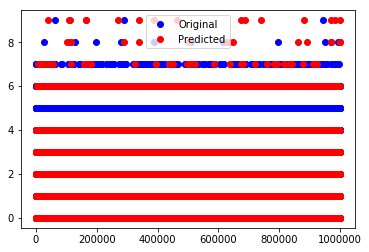

In [6]:
preds = [list(x) for x in model.predict(test_x)]
for i in range(len(preds)):
    preds[i] = preds[i].index(max(preds[i]))

test_matches = 0
for i in range(len(test_y)):
    if test_y[i] == preds[i]:
        test_matches += 1
        
print("Matches :", test_matches, '/', len(test_y), '=', test_matches/len(test_y) * 100)
print("Average Error :", sum([math.fabs(x-y) for x, y in zip(test_y, preds)])/len(test_y))
print("RMSE :", math.sqrt(sum([(x-y)**2 for x, y in zip(test_y, preds)])/len(test_y)))
    
plt.plot(test_y, 'bo', label='Original')
plt.plot(preds, 'ro', label='Predicted')
plt.legend()
plt.show()

In [7]:
scores = model.evaluate(train_x, train_y_onehot)
print("Train =", model.metrics_names[1], scores[1] * 100)

scores = model.evaluate(test_x, test_y_onehot)
print("Test =", model.metrics_names[1], scores[1] * 100)

25010/25010 [==============================] - 1s 27us/step
Train = acc 87.87684926124918
1000000/1000000 [==============================] - 24s 24us/step
Test = acc 83.0663


In [27]:
train_accuracies = list()
test_accuracies = list()

for iterations in range(50, 500, 50):
    model.fit(train_x, train_y_onehot, epochs = iterations, batch_size = 500, verbose=0)
    scores = model.evaluate(train_x, train_y_onehot, verbose=0)
    train_accuracies.append(scores[1]* 100)
    scores = model.evaluate(test_x, test_y_onehot, verbose=0)
    test_accuracies.append(scores[1]* 100)

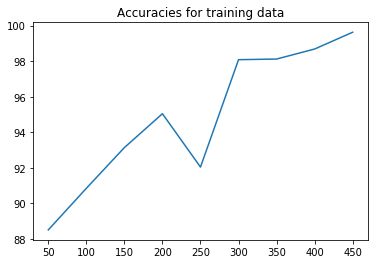

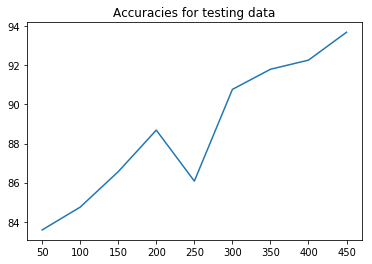

In [28]:
plt.title('Accuracies for training data')
plt.plot(range(50, 500, 50), train_accuracies)
plt.show()
plt.title('Accuracies for testing data')
plt.plot(range(50, 500, 50), test_accuracies)
plt.show()

In [8]:
confMat = [[0] * config.classes for x in range(config.classes)]

for i in range(len(preds)):
    predLabel = preds[i]
    actLabel = test_y[i]
    confMat[actLabel][predLabel] += 1

header = [""]
for l in range(config.classes):
    header.append("Pred " + str(l))
    
tab = PrettyTable(header)
l = 0
for c in confMat:
    tab.add_row(["Real " + str(l)] + c)
    l += 1

print(tab)

+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|        | Pred 0 | Pred 1 | Pred 2 | Pred 3 | Pred 4 | Pred 5 | Pred 6 | Pred 7 | Pred 8 | Pred 9 |
+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
| Real 0 | 475668 | 25289  |  125   |   22   |   93   |   0    |   0    |   0    |   1    |   11   |
| Real 1 | 94241  | 319272 |  6485  |  2024  |  456   |   0    |   10   |   0    |   10   |   0    |
| Real 2 |  2508  | 21625  | 22304  |  1096  |   16   |   0    |   68   |   4    |   1    |   0    |
| Real 3 |  569   |  7245  |  1173  | 12031  |   3    |   0    |   97   |   2    |   1    |   0    |
| Real 4 |  1045  |  1618  |  102   |   6    |  1108  |   0    |   0    |   0    |   1    |   5    |
| Real 5 |  1905  |   91   |   0    |   0    |   0    |   0    |   0    |   0    |   0    |   0    |
| Real 6 |   16   |  131   |  652   |  365   |   0    |   0    |  256   |   4    |   0    |